Hypothesis: There is a positive relationship between the amount of sleep a student gets and their average happiness throughout the day.

In [1]:
import pandas as pd

# Load the Excel file
file_path = "csit552_data.xlsx"
excel_file = pd.ExcelFile(file_path)
# Just process first 10 sheets for now
sheet_names = excel_file.sheet_names[:10]

#sheet_names = excel_file.sheet_names

# Define column groupings for each day (time, activity, who, where, happiness)
days = {
    "Monday": [1, 2, 3, 4, 5],
    "Tuesday": [6, 7, 8, 9, 10],
    "Wednesday": [11, 12, 13, 14, 15],
    "Thursday": [16, 17, 18, 19, 20],
    "Friday": [21, 22, 23, 24, 25],
    "Saturday": [26, 27, 28, 29, 30],
    "Sunday": [31, 32, 33, 34, 35]
}

cleaned_records = []

# Loop through each sheet
for sheet in sheet_names:
    try:
        df = pd.read_excel(file_path, sheet_name=sheet, header=None)
        num_cols = df.shape[1]

        for day, cols in days.items():
            if max(cols) >= num_cols:
                continue  # Skip incomplete days

            time_col, activity_col, _, _, happy_col = cols

            for i in range(5, len(df)):
                time = df.iloc[i, time_col]
                activity = df.iloc[i, activity_col]
                happiness = df.iloc[i, happy_col] if happy_col < num_cols else None

                if pd.notna(time) or pd.notna(activity):
                    cleaned_records.append({
                        "student_id": sheet,
                        "day": day,
                        "time": time,
                        "activity": str(activity).strip().lower() if pd.notna(activity) else None,
                        "happiness": happiness
                    })
    except Exception as e:
        print(f"Error in sheet {sheet}: {e}")

# Convert to DataFrame
df_cleaned = pd.DataFrame(cleaned_records)

# Optional: Normalize similar activities
activity_map = {
    "watch drama": "watching drama",
    "watch k drama": "watching drama",
    "netflix time": "watching drama",
    "nap": "sleep",
    "bathroom with phone": "phone time",
    "using phone": "phone time"
}
df_cleaned["activity"] = df_cleaned["activity"].replace(activity_map)

# Save to Excel
output_file = "cleaned_schedule_data.xlsx"
df_cleaned.to_excel(output_file, index=False)
print(f"Cleaned dataset saved as: {output_file}")


Cleaned dataset saved as: cleaned_schedule_data.xlsx


In [3]:
import pandas as pd

# Load cleaned file
df = pd.read_excel("cleaned_schedule_data.xlsx")

# Filter only sleep records
sleep_df = df[df['activity'] == 'sleep'].copy()

# Count total sleep per student per day
sleep_df['time'] = pd.to_datetime(sleep_df['time'], errors='coerce')
sleep_df['hour'] = sleep_df['time'].dt.hour + sleep_df['time'].dt.minute / 60

sleep_summary = sleep_df.groupby(['student_id', 'day']).agg(
    sleep_hours=('hour', 'count'),
    avg_happiness=('happiness', 'mean')
).reset_index()

print(sleep_summary.head())


              student_id     day  sleep_hours avg_happiness
0  A_2864065836498320281  Friday            1          10.0
1  A_2864065836498320281  Monday            1          10.0
2  A_3192327372956697596  Friday            0           8.0
3  A_3192327372956697596  Monday            2           9.0
4  A_3539122736994685137  Friday           17      8.441176


C:\Users\jderv\AppData\Local\Temp\ipykernel_21468\3133254242.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep_df['time'] = pd.to_datetime(sleep_df['time'], errors='coerce')


In [5]:
df = pd.read_excel("cleaned_schedule_data.xlsx")
print(df.shape)
print(df.head())


(1512, 5)
              student_id     day      time activity happiness
0  A_4195058507542523866  Monday  00:00:00    sleep       NaN
1  A_4195058507542523866  Monday  00:30:00      NaN       NaN
2  A_4195058507542523866  Monday  01:00:00      NaN       NaN
3  A_4195058507542523866  Monday  01:30:00      NaN       NaN
4  A_4195058507542523866  Monday  02:00:00      NaN       NaN


In [7]:
# Ensure happiness column is numeric
df['happiness'] = pd.to_numeric(df['happiness'], errors='coerce')

# Get average happiness per student/day
happy_summary = df.groupby(['student_id', 'day']).agg(
    avg_happiness=('happiness', 'mean')
).reset_index()


In [9]:
# Merge with sleep_summary
merged = pd.merge(sleep_summary, happy_summary, on=['student_id', 'day'])

print(merged.head())


              student_id     day  sleep_hours avg_happiness_x  avg_happiness_y
0  A_2864065836498320281  Friday            1            10.0         8.100000
1  A_2864065836498320281  Monday            1            10.0         8.250000
2  A_3192327372956697596  Friday            0             8.0         6.500000
3  A_3192327372956697596  Monday            2             9.0         6.307692
4  A_3539122736994685137  Friday           17        8.441176         7.996875


In [11]:
print("Days in sleep_summary:", sleep_summary['day'].unique())
print("Days in happy_summary:", happy_summary['day'].unique())


Days in sleep_summary: ['Friday' 'Monday' 'Thursday']
Days in happy_summary: ['Friday' 'Monday' 'Thursday' 'Tuesday' 'Wednesday']


In [13]:
print(sleep_summary['day'].value_counts())
print(happy_summary['day'].value_counts())


day
Friday      8
Monday      8
Thursday    1
Name: count, dtype: int64
day
Friday       10
Monday       10
Thursday     10
Tuesday      10
Wednesday    10
Name: count, dtype: int64


In [15]:
merged = pd.merge(sleep_summary, happy_summary, on=['student_id', 'day'], how='outer')


In [17]:
print(merged.head())

              student_id        day  sleep_hours avg_happiness_x  \
0  A_2864065836498320281     Friday          1.0            10.0   
1  A_2864065836498320281     Monday          1.0            10.0   
2  A_2864065836498320281   Thursday          NaN             NaN   
3  A_2864065836498320281    Tuesday          NaN             NaN   
4  A_2864065836498320281  Wednesday          NaN             NaN   

   avg_happiness_y  
0             8.10  
1             8.25  
2              NaN  
3              NaN  
4              NaN  


In [21]:
# Optional: fill missing sleep or happiness with 0 or mean
merged.fillna({
    'sleep_hours': 0,
    'avg_happiness_y': merged['avg_happiness_y'].mean()
}, inplace=True)


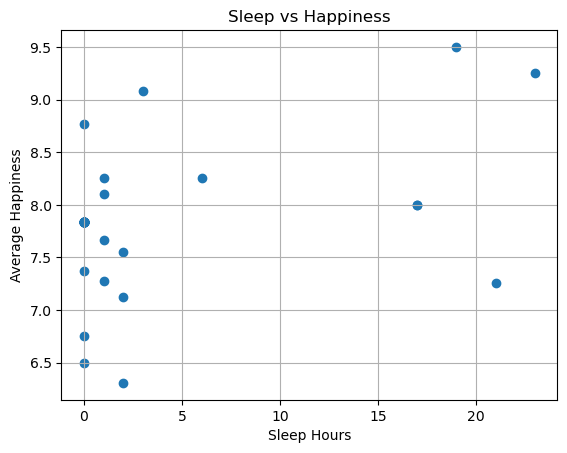

In [25]:
import matplotlib.pyplot as plt

plt.scatter(merged['sleep_hours'], merged['avg_happiness_y'])
plt.xlabel('Sleep Hours')
plt.ylabel('Average Happiness')
plt.title('Sleep vs Happiness')
plt.grid(True)
plt.show()



In [29]:
print(merged[['sleep_hours', 'avg_happiness_y']].corr())


                 sleep_hours  avg_happiness_y
sleep_hours         1.000000         0.375976
avg_happiness_y     0.375976         1.000000


In [31]:
print(merged.groupby('day')[['sleep_hours', 'avg_happiness_y']].mean())


           sleep_hours  avg_happiness_y
day                                    
Friday             4.4         7.983465
Monday             7.0         7.712536
Thursday           0.2         7.805429
Tuesday            0.0         7.833810
Wednesday          0.0         7.833810


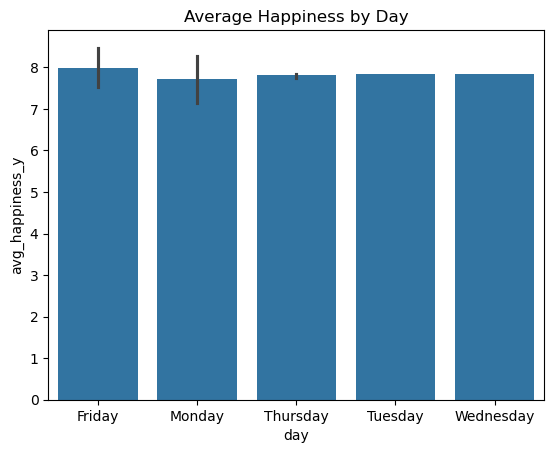

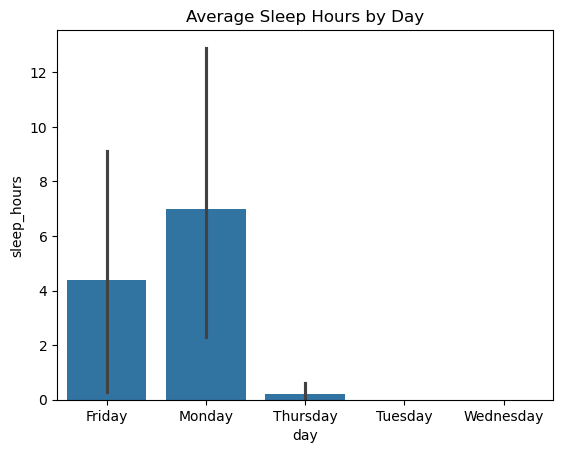

In [33]:
import seaborn as sns

sns.barplot(data=merged, x='day', y='avg_happiness_y')
plt.title("Average Happiness by Day")
plt.show()

sns.barplot(data=merged, x='day', y='sleep_hours')
plt.title("Average Sleep Hours by Day")
plt.show()


C:\Users\jderv\AppData\Local\Temp\ipykernel_21468\1439625215.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  happy_plot = sns.barplot(data=merged, x='day', y='avg_happiness_y', order=day_order, ax=axs[0], ci='sd')
C:\Users\jderv\AppData\Local\Temp\ipykernel_21468\1439625215.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sleep_plot = sns.barplot(data=merged, x='day', y='sleep_hours', order=day_order, ax=axs[1], ci='sd')


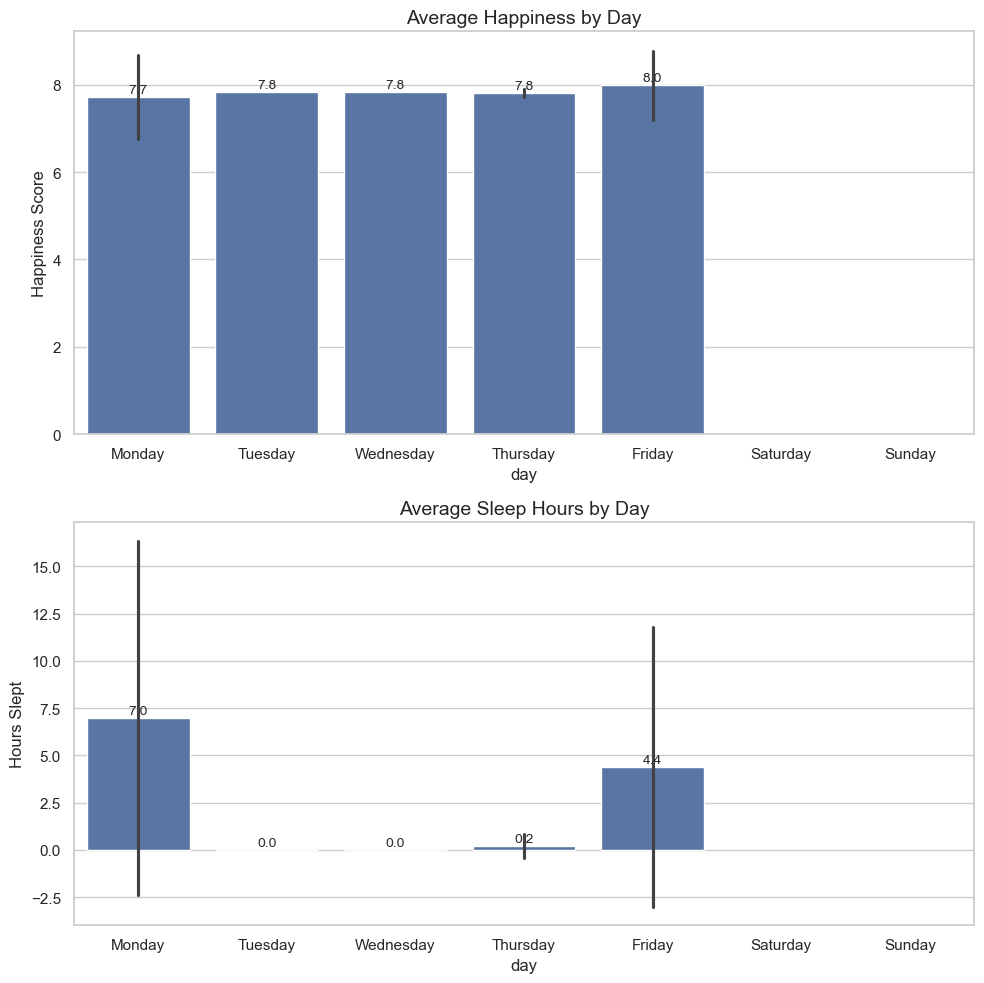

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: Ensure consistent day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set a cleaner theme
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# --- Average Happiness by Day ---
happy_plot = sns.barplot(data=merged, x='day', y='avg_happiness_y', order=day_order, ax=axs[0], ci='sd')
axs[0].set_title("Average Happiness by Day", fontsize=14)
axs[0].set_ylabel("Happiness Score")

# Add data labels
for bar in happy_plot.patches:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2., height + 0.1, f'{height:.1f}', ha='center', fontsize=10)

# --- Average Sleep Hours by Day ---
sleep_plot = sns.barplot(data=merged, x='day', y='sleep_hours', order=day_order, ax=axs[1], ci='sd')
axs[1].set_title("Average Sleep Hours by Day", fontsize=14)
axs[1].set_ylabel("Hours Slept")

# Add data labels
for bar in sleep_plot.patches:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2., height + 0.2, f'{height:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


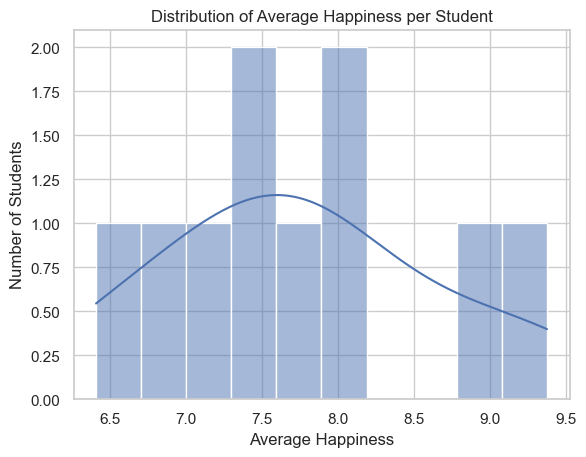

In [37]:
# Average happiness per student
overall_happy = df.groupby('student_id')['happiness'].mean().dropna()
sns.histplot(overall_happy, bins=10, kde=True)
plt.title("Distribution of Average Happiness per Student")
plt.xlabel("Average Happiness")
plt.ylabel("Number of Students")
plt.grid(True)
plt.show()


To evaluate overall mood levels across students, we calculated each student's average happiness score over the week and visualized the results in a histogram with a density curve. The distribution shows that most students reported average happiness scores between 7.0 and 8.0, indicating generally positive moods. A few students had lower averages around 6.5, while some reached highs around 9.0 or more. The shape of the distribution is slightly skewed right, suggesting a tendency toward higher happiness levels overall. This indicates that while most students feel moderately happy, there is still variability in mood among individuals.



To explore whether students feel happier at different times of day, we categorized each activity entry as either occurring in the morning (before 12 PM) or at night (after 12 PM). A boxplot comparison revealed that students generally reported slightly higher happiness levels in the morning, with a median score around 8.5 compared to 8.0 at night. Both time periods showed similar variability and ranges, but the morning group exhibited fewer extreme low values. While the difference is modest, the results suggest a small positive trend indicating that students may feel more content earlier in the day. Further data and analysis would be needed to confirm a statistically significant relationship.

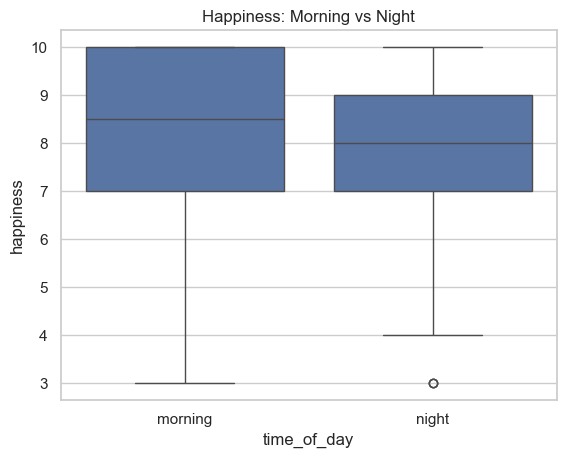

In [39]:
def classify_time(row):
    try:
        h = pd.to_datetime(row['time'], format='%H:%M:%S').hour
        return 'morning' if h < 12 else 'night'
    except:
        return None

df['time_of_day'] = df.apply(classify_time, axis=1)
sns.boxplot(data=df, x='time_of_day', y='happiness')
plt.title("Happiness: Morning vs Night")
plt.show()


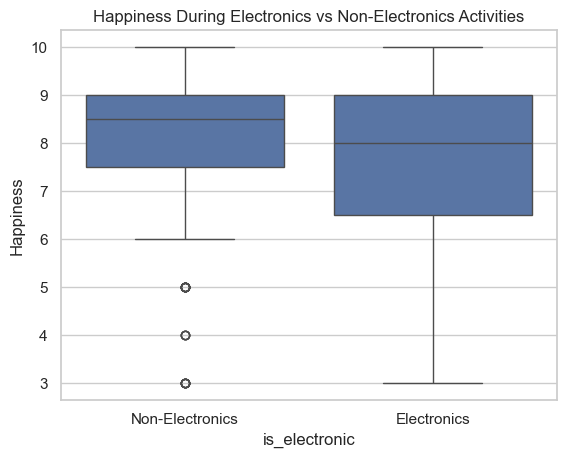

In [41]:
df['is_electronic'] = df['activity'].apply(lambda x: 1 if isinstance(x, str) and any(k in x for k in ['phone', 'tablet', 'netflix']) else 0)

sns.boxplot(data=df, x='is_electronic', y='happiness')
plt.xticks([0,1], ['Non-Electronics', 'Electronics'])
plt.title("Happiness During Electronics vs Non-Electronics Activities")
plt.ylabel("Happiness")
plt.show()


This analysis compares happiness levels during electronic-related activities (such as phone, tablet, and Netflix use) versus all other activities. The boxplot shows that the median happiness scores are nearly the same for both groups, hovering around 8–9. However, the non-electronics group has more low outliers, indicating that some students feel significantly less happy during non-digital tasks. On the other hand, electronics-related activities show slightly less variation, with a tighter interquartile range. These results suggest that while using electronic devices may not dramatically increase happiness, students tend to feel consistently content while engaged in them. The overall mood during screen time is generally positive and stable.



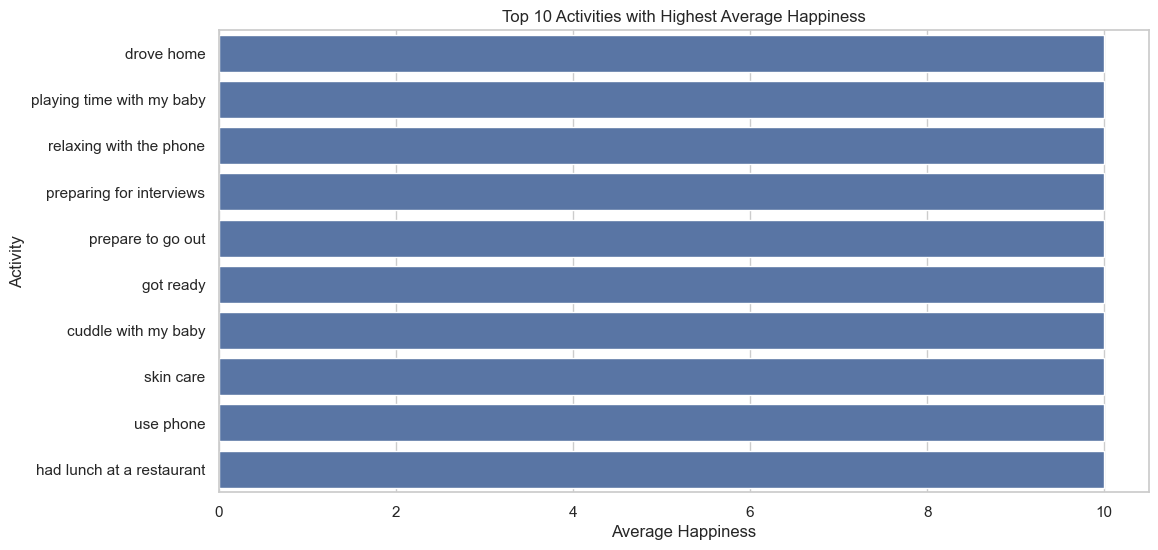

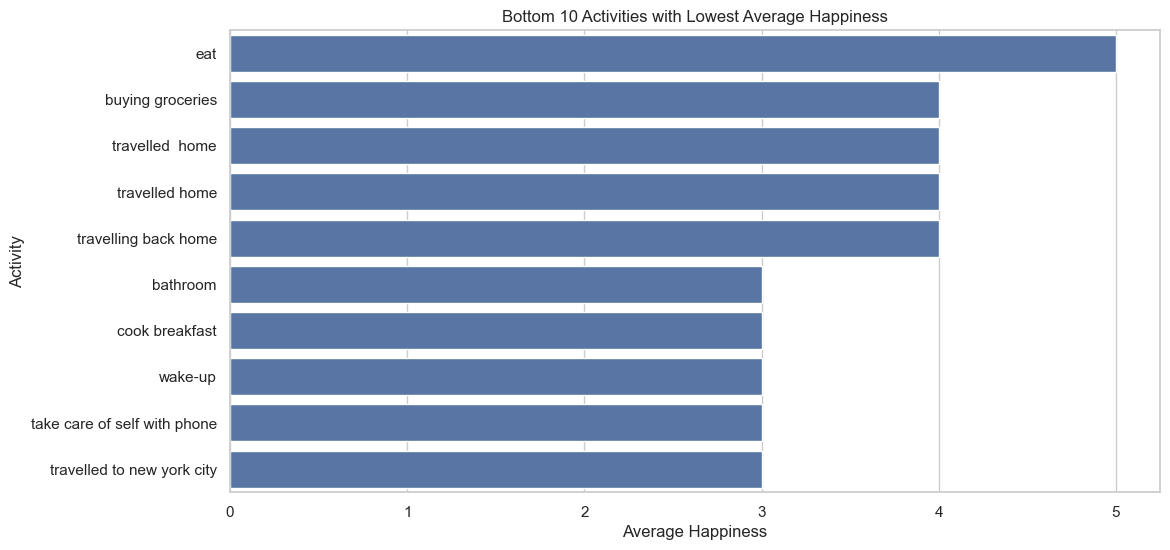

In [43]:
# Group by activity and calculate average happiness
activity_happiness = df.groupby('activity')['happiness'].mean().dropna().sort_values(ascending=False)

# Plot top 10 most liked and least liked
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_happiness.head(10).values, y=activity_happiness.head(10).index)
plt.title("Top 10 Activities with Highest Average Happiness")
plt.xlabel("Average Happiness")
plt.ylabel("Activity")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=activity_happiness.tail(10).values, y=activity_happiness.tail(10).index)
plt.title("Bottom 10 Activities with Lowest Average Happiness")
plt.xlabel("Average Happiness")
plt.ylabel("Activity")
plt.show()
